In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# Check if MPS (Metal Performance Shaders) is available (for M1 Macs)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
# 1. Data Preprocessing
# (a) Load MNIST dataset and split into training (50k), validation (10k), and test (10k) sets

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to (-1, 1)
])

# Download and load the dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split full_train_dataset into training and validation sets
train_dataset = Subset(full_train_dataset, range(0, 50000))
val_dataset = Subset(full_train_dataset, range(50000, 60000))

In [3]:
# 2. Minibatch Training
batch_sizes = [1, 10, 100, 1000]
num_epochs = 20
ce_loss_vs_iteration = {}
ce_loss_vs_epoch = {}
lowest_loss_per_batchsize = {}
epochs_to_lowest_loss = {}

# Define the model
class MLRModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLRModel, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
        
    def forward(self, x):
        outputs = self.linear(x)
        return outputs

# Function to compute CE loss over the entire dataset
def compute_loss(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():  # Disable gradient computation
        for images, labels in data_loader:
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            batch_size = images.size(0)
            total_loss += loss.item() * batch_size  # Multiply by batch size
            total_samples += batch_size
    average_loss = total_loss / total_samples
    model.train()  # Set the model back to training mode
    return average_loss

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # For computing loss over the entire training data
    full_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    # Initialize the model
    input_dim = 28 * 28
    num_classes = 10
    model = MLRModel(input_dim, num_classes).to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    # Training
    total_steps = len(train_loader)
    ce_loss_list = []
    ce_loss_epoch_list = []
    iteration = 0
    lowest_loss = float('inf')
    epoch_of_lowest_loss = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Flatten images
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            iteration += 1
            # Compute CE loss every 5000 / batch_size iterations (10 times per epoch)
            if (i + 1) % max(1, total_steps // 10) == 0:
                avg_loss = running_loss / max(1, total_steps // 10)
                ce_loss_list.append(avg_loss)
                running_loss = 0.0
        # Recompute CE loss over the entire training data at the end of each epoch
        average_epoch_loss = compute_loss(model, full_train_loader, criterion)
        ce_loss_epoch_list.append(average_epoch_loss)
        # Check for lowest loss
        if ce_loss_epoch_list[-1] < lowest_loss:
            lowest_loss = ce_loss_epoch_list[-1]
            epoch_of_lowest_loss = epoch + 1
    # Store results
    ce_loss_vs_iteration[batch_size] = ce_loss_list
    ce_loss_vs_epoch[batch_size] = ce_loss_epoch_list
    lowest_loss_per_batchsize[batch_size] = lowest_loss
    epochs_to_lowest_loss[batch_size] = epoch_of_lowest_loss


Training with batch size: 1

Training with batch size: 10

Training with batch size: 100

Training with batch size: 1000


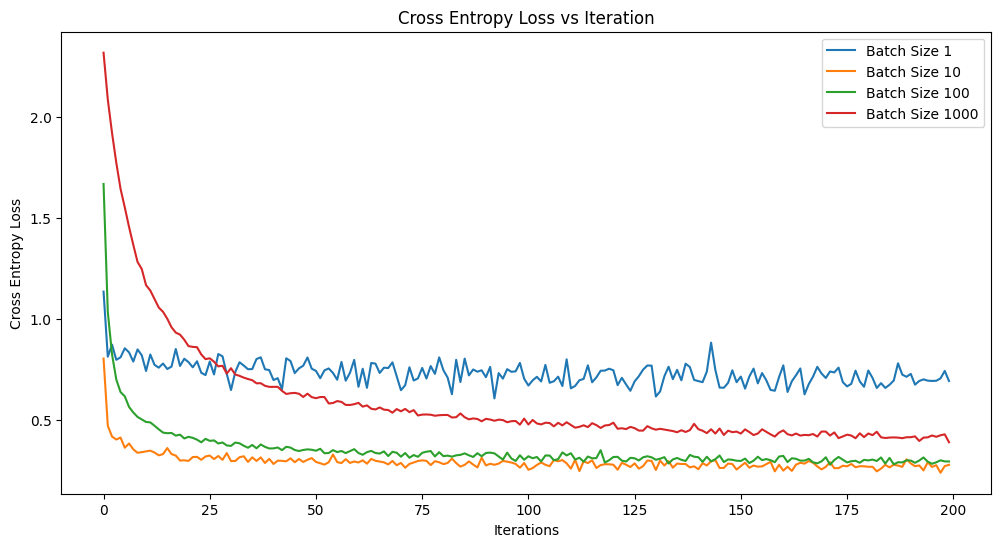

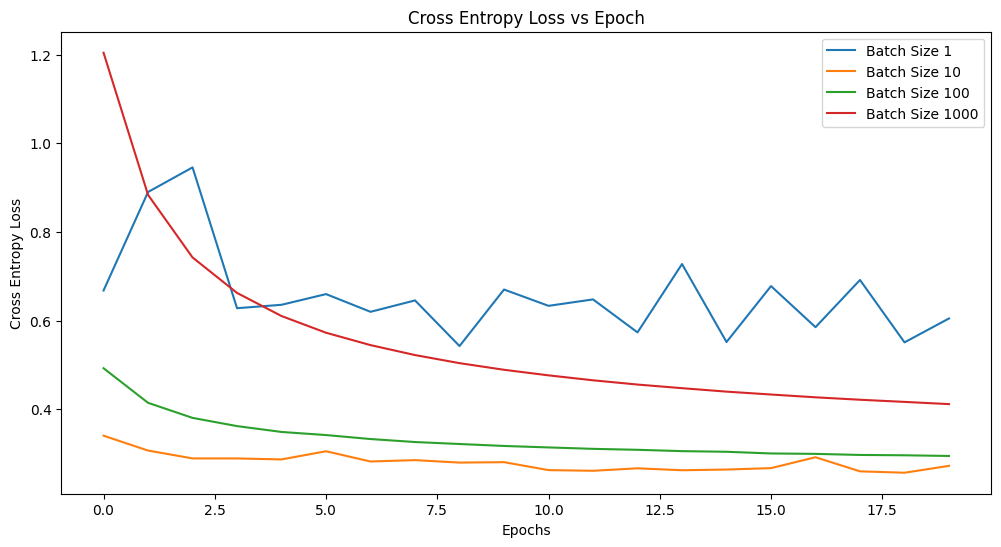

In [4]:
# 2(b) Plot CE loss vs iteration and CE loss vs epoch
import math

# Plot CE loss vs iteration
plt.figure(figsize=(12, 6))
for batch_size in batch_sizes:
    plt.plot(ce_loss_vs_iteration[batch_size], label=f'Batch Size {batch_size}')
plt.title('Cross Entropy Loss vs Iteration')
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

# Plot CE loss vs epoch
plt.figure(figsize=(12, 6))
for batch_size in batch_sizes:
    plt.plot(ce_loss_vs_epoch[batch_size], label=f'Batch Size {batch_size}')
plt.title('Cross Entropy Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

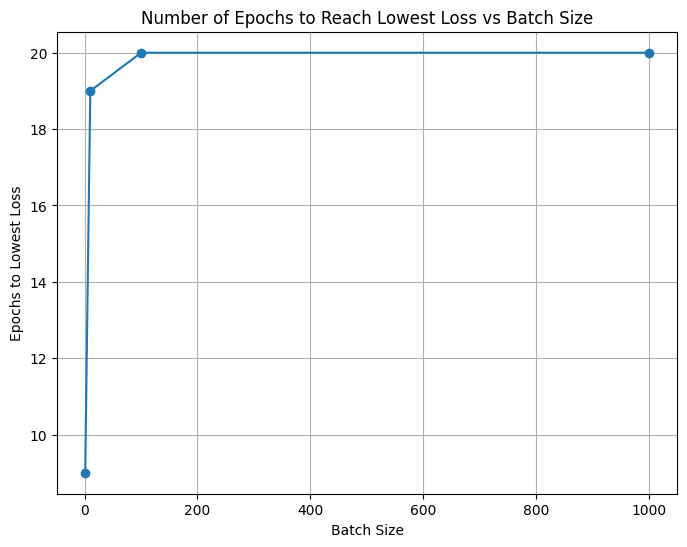

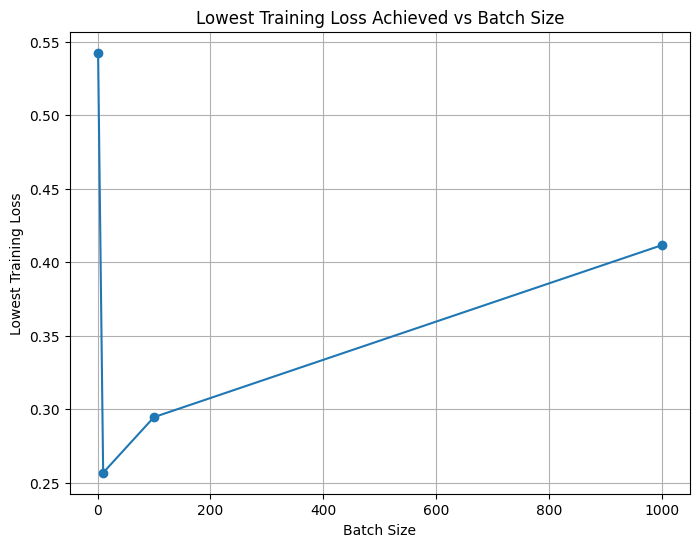

In [5]:
# 2(c) Plot number of epochs to reach lowest loss and lowest training loss vs batch size
batch_sizes_array = np.array(batch_sizes)

# Plot number of epochs to reach lowest loss vs batch size
epochs_needed = [epochs_to_lowest_loss[bs] for bs in batch_sizes]
plt.figure(figsize=(8, 6))
plt.plot(batch_sizes_array, epochs_needed, marker='o')
plt.title('Number of Epochs to Reach Lowest Loss vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Epochs to Lowest Loss')
plt.grid(True)
plt.show()

# Plot lowest training loss achieved vs batch size
lowest_losses = [lowest_loss_per_batchsize[bs] for bs in batch_sizes]
plt.figure(figsize=(8, 6))
plt.plot(batch_sizes_array, lowest_losses, marker='o')
plt.title('Lowest Training Loss Achieved vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Lowest Training Loss')
plt.grid(True)
plt.show()


Training with weight decay (λ) = 0

Training with weight decay (λ) = 0.01

Training with weight decay (λ) = 0.1

Training with weight decay (λ) = 1


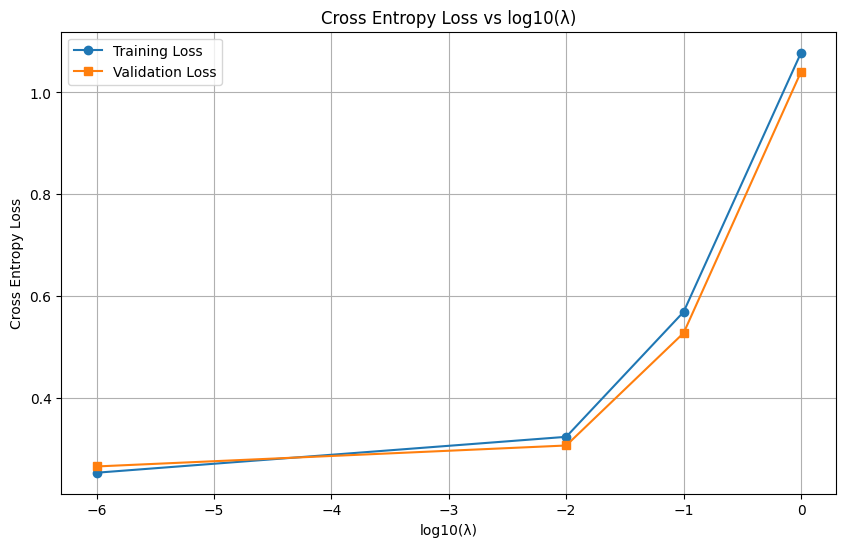

Best λ based on validation loss: 0


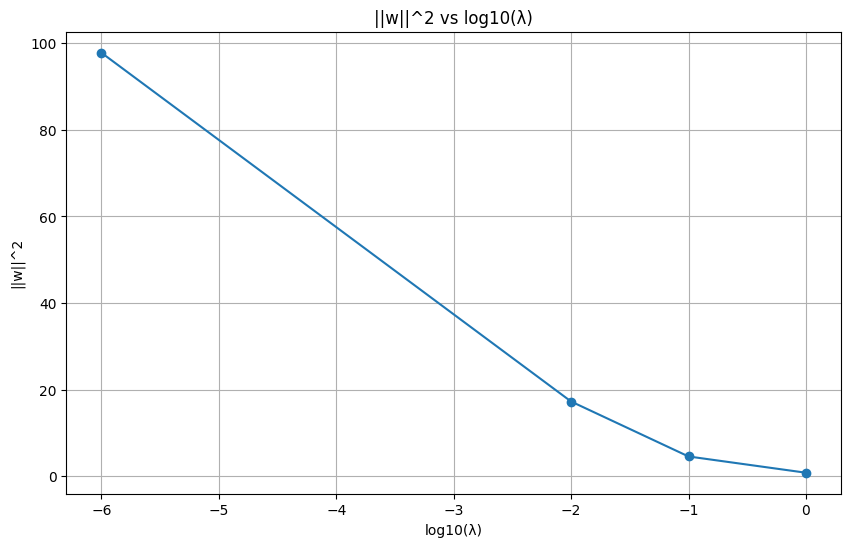

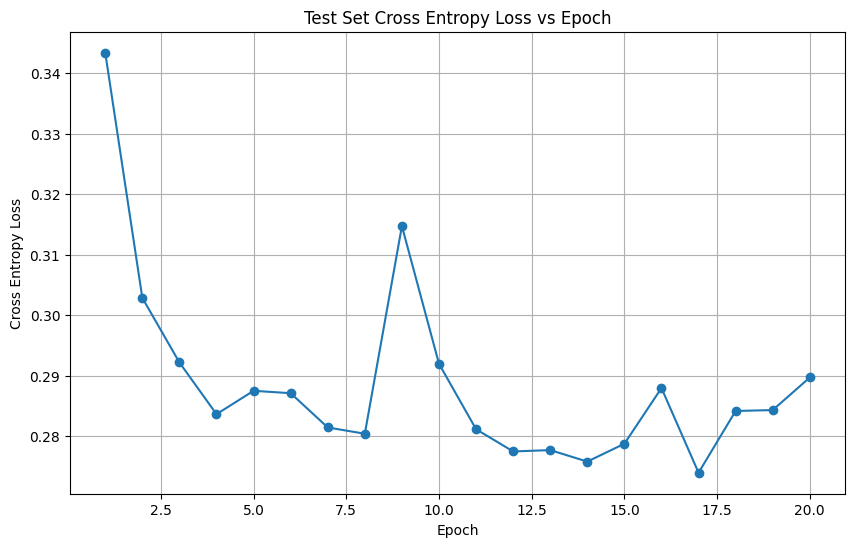

In [6]:
from torch.utils.data import DataLoader, Subset, ConcatDataset

# 2. Weight Decay Experiment
batch_size = 10  # Selected batch size from part (2)
num_epochs = 20
lambdas = [0, 0.01, 0.1, 1]
train_losses = {}
val_losses = {}
weight_norms = {}

for lam in lambdas:
    print(f"\nTraining with weight decay (λ) = {lam}")
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
    # Initialize the model
    input_dim = 28 * 28
    num_classes = 10
    model = MLRModel(input_dim, num_classes).to(device)
    # Loss and optimizer with weight decay (L2 regularization)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=lam)
    # Training
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            # Flatten images
            images = images.view(-1, 28*28).to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    # Compute CE loss on training and validation sets
    full_train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=False)
    train_loss = compute_loss(model, full_train_loader, criterion)
    val_loss = compute_loss(model, val_loader, criterion)
    train_losses[lam] = train_loss
    val_losses[lam] = val_loss
    # Compute ||w||^2
    with torch.no_grad():
        w_norm = 0.0
        for param in model.parameters():
            w_norm += torch.sum(param.data ** 2).item()
        weight_norms[lam] = w_norm

# 3. Plot CE loss on training and validation sets vs λ
lambdas_log = [np.log10(lam + 1e-6) if lam > 0 else -6 for lam in lambdas]  # Handle log(0)
plt.figure(figsize=(10, 6))
plt.plot(lambdas_log, [train_losses[lam] for lam in lambdas], marker='o', label='Training Loss')
plt.plot(lambdas_log, [val_losses[lam] for lam in lambdas], marker='s', label='Validation Loss')
plt.title('Cross Entropy Loss vs log10(λ)')
plt.xlabel('log10(λ)')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()

# 4. Discuss observations and report best λ
best_lambda = min(val_losses, key=val_losses.get)
print(f"Best λ based on validation loss: {best_lambda}")

# 5. Plot ||w||^2 vs λ
plt.figure(figsize=(10, 6))
plt.plot(lambdas_log, [weight_norms[lam] for lam in lambdas], marker='o')
plt.title('||w||^2 vs log10(λ)')
plt.xlabel('log10(λ)')
plt.ylabel('||w||^2')
plt.grid(True)
plt.show()

# 6. Train on the combined training data (train + validation sets) using the best λ
combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Initialize the model
model = MLRModel(input_dim, num_classes).to(device)
# Loss and optimizer with best λ
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=best_lambda)

# Training on combined data
test_losses = []
for epoch in range(num_epochs):
    for images, labels in combined_loader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Compute CE loss on test set at the end of each epoch
    test_loss = compute_loss(model, test_loader, criterion)
    test_losses.append(test_loss)

# Plot testing loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), test_losses, marker='o')
plt.title('Test Set Cross Entropy Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.grid(True)
plt.show()